In [4]:
import pandas as pd
import numpy as np 
import re

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
sns.set()
# # used for better images in medium article
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# Required downloads for use with above models
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

<ol>
    <li>Clean text
        <ul>
            <li> Parse words
            <li> Remove all special characters
            <li> Cleaned formatting
        </ul>
    <li> Tokenize
         <ul>
             <li> Words
             <li> Sentences
        </ul>
    <li> Counts
         <ul>
             <li> Word Count w/ visualization
             <li> Sentence Count w/ visualization
        </ul>
    <li> Stop Word Removal 
    <li> Stemitization
    <li> Lemmatization
    <li> create one large corpus for analysis               
    <li>POS Tagging Analysis
         <ul>
             <li> Identify the POS of interest
             <li> Chunking for phrases rdf triplets similar use
             <li> NE Dictionary for NER
             <li> Are there any patterns associated with their use, lexical grammatical?
         </ul>
    <li> Frequent Words
         <ul>
             <li> N-Grams
             <li> BiGrams
             <li> TriGrams
             <li> Matched with any patterns from POS and determine any importance?
        </ul>
    <li> Topic Model Test
         <ul>
             <li> LDA
             <li> LSA?
             <li> LDA Visualization
             <li> Any use case specifics, matters of importance?
             <li> topic analyses
        </ul>
    <li> Text Rank for keyword extraction   
    <li> TF-IDF
    <li> RAKE
    <li> Text Rank *
    <li> Clustering
    <li> BERT Q&A
</ol>

In [5]:
df = pd.read_csv(r'data\collected_data\indeed_job_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        5715 non-null   int64  
 1   Job_Title                         5715 non-null   object 
 2   Link                              5715 non-null   object 
 3   Queried_Salary                    5715 non-null   object 
 4   Job_Type                          5715 non-null   object 
 5   Skill                             5483 non-null   object 
 6   No_of_Skills                      5715 non-null   int64  
 7   Company                           5611 non-null   object 
 8   No_of_Reviews                     4753 non-null   float64
 9   No_of_Stars                       4753 non-null   float64
 10  Date_Since_Posted                 5611 non-null   float64
 11  Description                       5413 non-null   object 
 12  Locati

In [6]:
# scaling down the dataset as the description is all that is required
df_desc = df.Description

In [7]:
# random choice to get a sense of the data formatting and cell to check other indices
df_desc.iloc[598]

"[<p>Seattle City Light, a department of the City of Seattle, is one of the nation's largest municipally owned utilities in terms of the number of customers served. Over the years we have worked very hard to keep Seattle's electricity affordable, reliable, and environmentally sound. Today, City Light is a recognized national leader in energy efficiency and environmental stewardship.<br/>\r\r\n<br/>\r\r\nThe Resource Planning, Forecasting and Analysis team (RPFA) is looking for a quantitatively capable individual who wants to apply their modeling skills and mathematical expertise to electric resource planning and hydro operations planning. Seattle City Light is adapting to significant and exciting changes in the electric industry and the RPFA team is looking for talented individuals to help meet those challenges by enhancing the modeling and decision analysis capabilities of the team.<br/>\r\r\n<br/>\r\r\nThis position will report to the Resource Planning, Forecasting &amp; Analysis Man

In [8]:
def clean_text(raw):
    '''Case specific to be used with pandas apply method'''
    try:
        # remove carriage returns and new lines
        raw = raw.replace('\r', '')
        raw = raw.replace('\n', '')
        
        # brackets appear in all instances
        raw = raw.replace('[', '')
        raw = raw.replace(']', '')
        raw = raw.replace(')', '')
        raw = raw.replace('(', '')
        
        # removing html tags
        clean_html = re.compile('<.*?>')
        clean_text = re.sub(clean_html, ' ', raw)
        
        # removing duplicate whitespace in between words
        clean_text = re.sub(" +", " ", clean_text) 
        
        # stripping first and last white space 
        clean_text = clean_text.strip()
        
        # commas had multiple spaces before and after in each instance
        clean_text = re.sub(" , ", ", ", clean_text) 
        
        # eliminating the extra comma after a period
        clean_text = clean_text.replace('.,', '.')
        
        # using try and except due to Nan in the column
    except:
        clean_text = np.nan
        
    return clean_text

In [9]:
df_desc = df_desc.apply(clean_text)
df_desc.iloc[598]

"Seattle City Light, a department of the City of Seattle, is one of the nation's largest municipally owned utilities in terms of the number of customers served. Over the years we have worked very hard to keep Seattle's electricity affordable, reliable, and environmentally sound. Today, City Light is a recognized national leader in energy efficiency and environmental stewardship. The Resource Planning, Forecasting and Analysis team RPFA is looking for a quantitatively capable individual who wants to apply their modeling skills and mathematical expertise to electric resource planning and hydro operations planning. Seattle City Light is adapting to significant and exciting changes in the electric industry and the RPFA team is looking for talented individuals to help meet those challenges by enhancing the modeling and decision analysis capabilities of the team. This position will report to the Resource Planning, Forecasting &amp; Analysis Manager. The person in this position will lead and 

In [10]:
# Precentage of missing values on all the total rows
total_len = len(df)
missing_rows = df['Description'].isnull().sum()
precent_missing = (missing_rows/total_len)*100
print(f'Total Rows: {total_len}\nMissing Rows: {missing_rows}\nPercent Missing: {precent_missing:.2f}%')

Total Rows: 5715
Missing Rows: 302
Percent Missing: 5.28%


In [11]:
# change the type from series to df and drop all missing values total: 301 missing descriptions
df_desc = pd.DataFrame(df_desc)
df_desc.dropna(inplace = True)
df_desc.reset_index(inplace = True, drop = True)

In [12]:
# Precentage of missing values on all the total rows
total_len = len(df_desc)
missing_rows = df_desc['Description'].isnull().sum()
precent_missing = (missing_rows/total_len)*100
print(f'Total Rows: {total_len}\nMissing Rows: {missing_rows}\nPercent Missing: {precent_missing:.2f}%')

Total Rows: 5413
Missing Rows: 0
Percent Missing: 0.00%


# Tokenization

In [13]:
# create a temp column for lowercased description
df_desc['lower_description'] = df_desc.Description.str.lower()

In [14]:
# regexp tokenizer eliminates the punctuation for the word count and is faster than word_tokenizer
tokenizer = RegexpTokenizer(r"\w+")
df_desc['word_tokenized'] = df_desc.lower_description.apply(lambda row: tokenizer.tokenize(row))


In [15]:
# ensure the punkt tokenizer data is available (nltk was imported in an earlier cell)
for resource, pkg in (('tokenizers/punkt', 'punkt'), ('tokenizers/punkt_tab', 'punkt_tab')):
	try:
		nltk.data.find(resource)
	except LookupError:
		# try downloading the package; quiet=True to reduce output in notebook
		try:
			nltk.download(pkg, quiet=True)
		except:
			# ignore download errors here; fallback below will handle tokenization
			pass

# Tokenize sentences, guarding against non-string / NaN values and providing a safe fallback
def safe_sent_tokenize(text):
	if not isinstance(text, str):
		return []
	try:
		return sent_tokenize(text)
	except LookupError:
		# fallback: simple sentence split by punctuation if punkt is unavailable
		return [s.strip() for s in re.split(r'[.?!]\s+', text) if s.strip()]

df_desc['sentence_tokenized'] = df_desc['Description'].apply(safe_sent_tokenize)

In [16]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Description         5413 non-null   object
 1   lower_description   5413 non-null   object
 2   word_tokenized      5413 non-null   object
 3   sentence_tokenized  5413 non-null   object
dtypes: object(4)
memory usage: 169.3+ KB


In [17]:
df_desc.word_tokenized.head()

0    [position, summary, the, business, analyst, ro...
1    [what, do, we, need, you, to, have, an, amazin...
2    [validate, analyze, and, conduct, statistical,...
3    [full, time, washington, dc, metro, area, star...
4    [assist, in, consultations, with, business, pa...
Name: word_tokenized, dtype: object

In [18]:
df_desc.sentence_tokenized.head()

0    [POSITION SUMMARY, The Business Analyst role i...
1    [What do we need?, You to have an amazing pers...
2    [Validate, analyze, and conduct statistical an...
3    [Full time, Washington, DC metro area, Startin...
4    [Assist in consultations with business partner...
Name: sentence_tokenized, dtype: object

# Word Count

In [19]:
# obtains a word count for each individual job description 
df_desc['word_count'] = df_desc.word_tokenized.str.len()

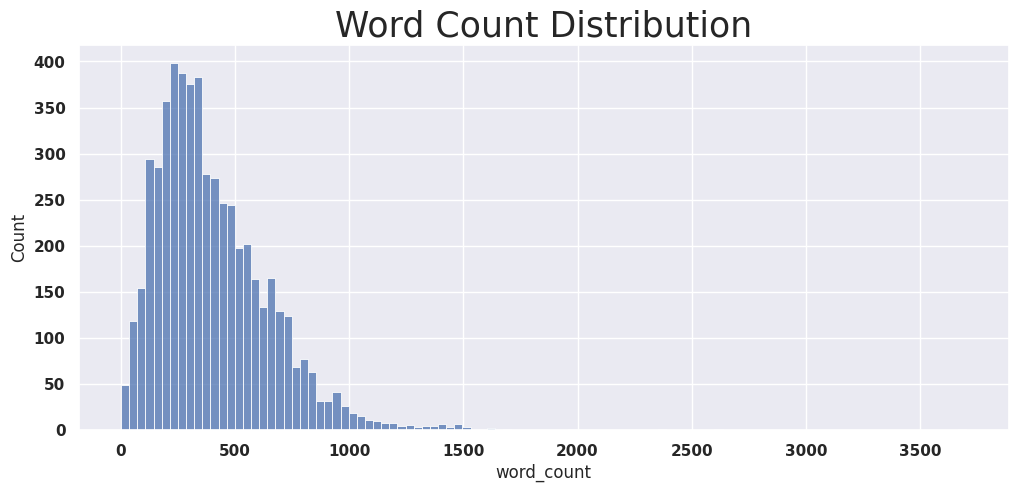

In [20]:
import logging
# Đặt cấp độ ghi nhật ký của Matplotlib font manager thành ERROR hoặc CRITICAL
# Điều này sẽ ngăn các cảnh báo (WARNING) và thông báo thông thường (INFO) hiển thị
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

plt.figure(figsize = (12,5))
sns.histplot(df_desc['word_count'])
plt.title('Word Count Distribution', size = 25);

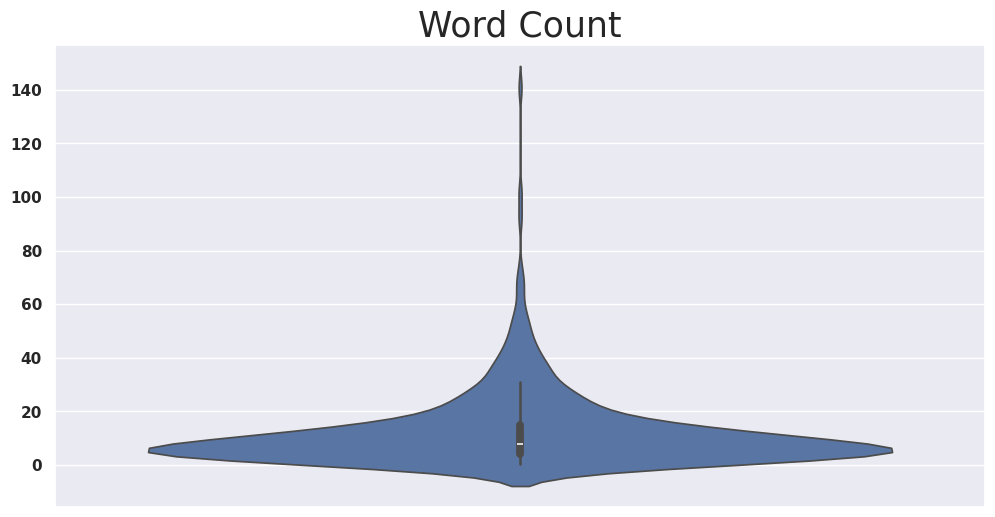

In [21]:
import logging
# Đặt cấp độ ghi nhật ký của Matplotlib font manager thành ERROR hoặc CRITICAL
# Điều này sẽ ngăn các cảnh báo (WARNING) và thông báo thông thường (INFO) hiển thị
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Sau đó chạy code vẽ biểu đồ của bạn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Sử dụng dữ liệu thực tế của bạn thay cho df_desc["word_count"]
# Ví dụ, tạo dữ liệu giả định để minh họa:
import numpy as np
data = np.random.lognormal(mean=2, sigma=1, size=500)
sns.violinplot(data) 
plt.title('Word Count', size=25)
plt.show() # Thêm plt.show() để hiển thị biểu đồ

# Sentence Count

In [22]:
# obtains sentence count for each indiviual job description
df_desc['sentence_count'] = df_desc.sentence_tokenized.str.len()

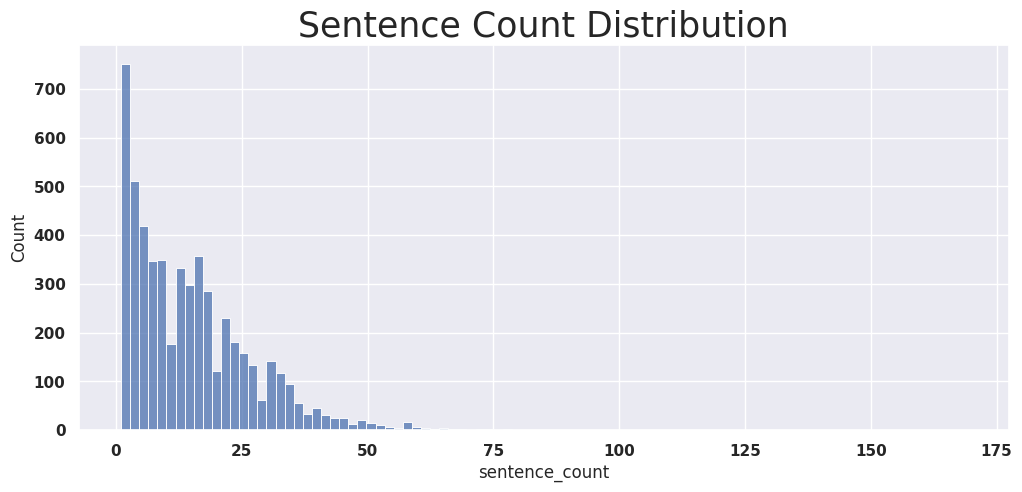

In [23]:
import logging
# Đặt cấp độ ghi nhật ký của Matplotlib font manager thành ERROR hoặc CRITICAL
# Điều này sẽ ngăn các cảnh báo (WARNING) và thông báo thông thường (INFO) hiển thị
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.figure(figsize = (12,5))
sns.histplot(df_desc['sentence_count'])
plt.title('Sentence Count Distribution', size = 25);

# Descriptive Statistics

In [24]:
df_desc.describe()

,word_count,sentence_count
count,5413.000000,5413.000000
mean,400.587290,15.037133
std,249.264893,12.912989
min,0.000000,1.000000
25%,223.000000,5.000000
50%,347.000000,12.000000
75%,537.000000,21.000000
max,3704.000000,169.000000


In [25]:
# indices to be removed were examined by description of observations who's value were below 11; 
# extra indices included are redundant or had no relevant info;
extra_indices = [20, 21, 36, 155, 428, 478, 685, 900, 1008, 1009]
indices_remove =  df_desc.loc[df_desc.word_count <= 12].index 
indices_remove = list(indices_remove) + extra_indices
print(len(indices_remove), 'observations to be removed')

42 observations to be removed


In [26]:
df_desc.drop(indices_remove, inplace = True)

In [27]:
print(5413 - df_desc.shape[0], 'observations have been removed. Resulting in', df_desc.shape[0], 'observations within the dataset.')

34 observations have been removed. Resulting in 5379 observations within the dataset.


# Stop Words

In [28]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5379 entries, 0 to 5412
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Description         5379 non-null   object
 1   lower_description   5379 non-null   object
 2   word_tokenized      5379 non-null   object
 3   sentence_tokenized  5379 non-null   object
 4   word_count          5379 non-null   int64 
 5   sentence_count      5379 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 294.2+ KB


In [29]:
df_desc.head()

,Description,lower_description,word_tokenized,sentence_tokenized,word_count,sentence_count
0,"POSITION SUMMARY, The Business Analyst role is...","position summary, the business analyst role is...","[position, summary, the, business, analyst, ro...","[POSITION SUMMARY, The Business Analyst role i...",424,25
1,"What do we need?, You to have an amazing perso...","what do we need?, you to have an amazing perso...","[what, do, we, need, you, to, have, an, amazin...","[What do we need?, You to have an amazing pers...",286,10
2,"Validate, analyze, and conduct statistical ana...","validate, analyze, and conduct statistical ana...","[validate, analyze, and, conduct, statistical,...","[Validate, analyze, and conduct statistical an...",314,24
3,"Full time, Washington, DC metro area, Starting...","full time, washington, dc metro area, starting...","[full, time, washington, dc, metro, area, star...","[Full time, Washington, DC metro area, Startin...",297,13
4,Assist in consultations with business partners...,assist in consultations with business partners...,"[assist, in, consultations, with, business, pa...",[Assist in consultations with business partner...,316,7


In [30]:
def stopword_removal(text):
    stop_words = set(stopwords.words('english'))
    cleaned = [word for word in text if word not in stop_words]
    return cleaned

In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\sora
[nltk_data]     sama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
df_desc['clean_words'] = df_desc.word_tokenized.apply(stopword_removal)

# Stemming & Lemmatization

In [33]:
# stemmed and lemma words were both examined to choose which method was best suited
def stemming(text):
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in text]
    return stemmed

def lemming(text):
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in text]
    return lemmed

In [34]:
df_desc['clean_stemmed'] = df_desc.clean_words.apply(stemming)

In [35]:
# ensure required NLTK corpora for lemmatization are available
try:
	nltk.data.find('corpora/wordnet')
except LookupError:
	nltk.download('wordnet', quiet=True)

# optional: some NLTK setups require the omw resource for lemmatizer
try:
	nltk.data.find('corpora/omw-1.4')
except LookupError:
	nltk.download('omw-1.4', quiet=True)

# apply lemmatization now that resources are available
df_desc['clean_lemmed'] = df_desc.clean_words.apply(lemming)

In [36]:
df_desc['clean_lemmed'].head()

0    [position, summary, business, analyst, role, p...
1    [need, amazing, personality, communication, st...
2    [validate, analyze, conduct, statistical, anal...
3    [full, time, washington, dc, metro, area, star...
4    [assist, consultation, business, partner, inte...
Name: clean_lemmed, dtype: object

In [37]:
# general corpus & one distinguished with lemmatization applied
# to be used with an additional for loop in the future
lem_corpus = []
for row in df_desc.clean_lemmed:
    lem_corpus += row

In [38]:
stem_corpus = []
for row in df_desc.clean_stemmed:
    stem_corpus += row

In [39]:
len(stem_corpus), len(lem_corpus)

(1490203, 1490203)

# Frequent Words 

## (Stemmed)

In [40]:
def get_top_n_words(corpus):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

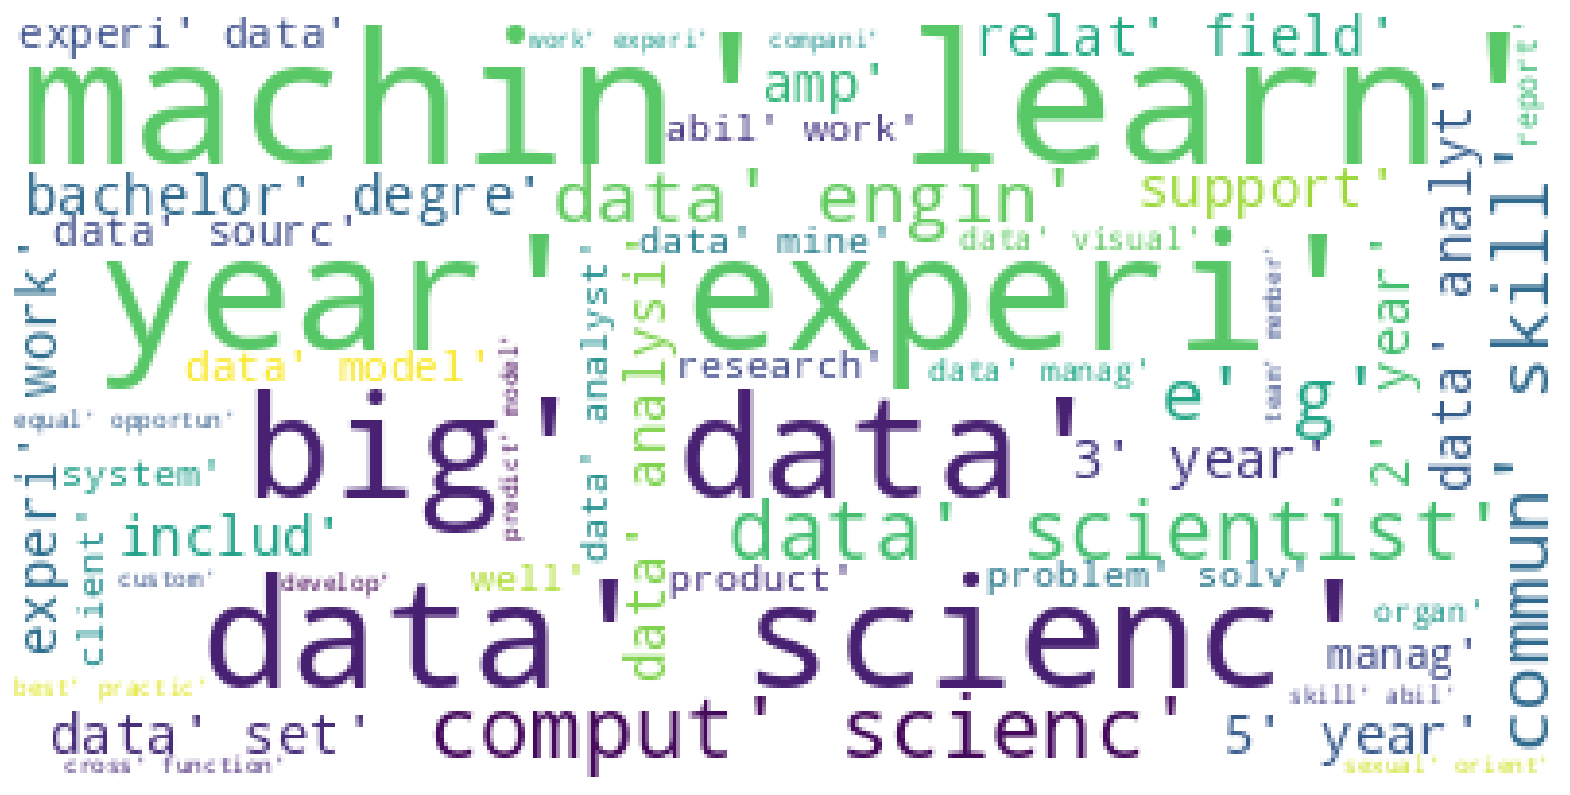

In [41]:
stem_wordcloud = WordCloud(
                          background_color='white',
                          max_words=100,
                          max_font_size=50, 
                          min_font_size = 6,
                          random_state=42
                         ).generate(str(stem_corpus))

fig = plt.figure(1, figsize = (20,15))
plt.imshow(stem_wordcloud)
plt.axis('off')

In [42]:
#Convert most freq words to dataframe for plotting bar plot
top_stem_words = get_top_n_words(stem_corpus)
top_stem = pd.DataFrame(top_stem_words)
top_stem.columns=["Word", "Freq"]


In [43]:
top_stem.head()
# top_stem.tail()

,Word,Freq
0,data,53690
1,experi,28058
2,work,17209
3,develop,14530
4,busi,14217


In [44]:
top_stem.describe()

,Freq
count,14551.000000
mean,100.898220
std,737.060776
min,1.000000
25%,1.000000
50%,3.000000
75%,15.000000
max,53690.000000


C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\1469120626.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  stem_bar = sns.barplot(x="Word", y="Freq", data=top_stem[:21], palette="Blues_d")
C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\1469120626.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  stem_bar.set_xticklabels(stem_bar.get_xticklabels(), rotation=30, fontsize = 10)


[Text(0, 0, 'data'),
 Text(1, 0, 'experi'),
 Text(2, 0, 'work'),
 Text(3, 0, 'develop'),
 Text(4, 0, 'busi'),
 Text(5, 0, 'analyt'),
 Text(6, 0, 'team'),
 Text(7, 0, 'model'),
 Text(8, 0, 'manag'),
 Text(9, 0, 'skill'),
 Text(10, 0, 'learn'),
 Text(11, 0, 'year'),
 Text(12, 0, 'use'),
 Text(13, 0, 'abil'),
 Text(14, 0, 'requir'),
 Text(15, 0, 'product'),
 Text(16, 0, 'analysi'),
 Text(17, 0, 'scienc'),
 Text(18, 0, 'engin'),
 Text(19, 0, 'process'),
 Text(20, 0, 'solut')]

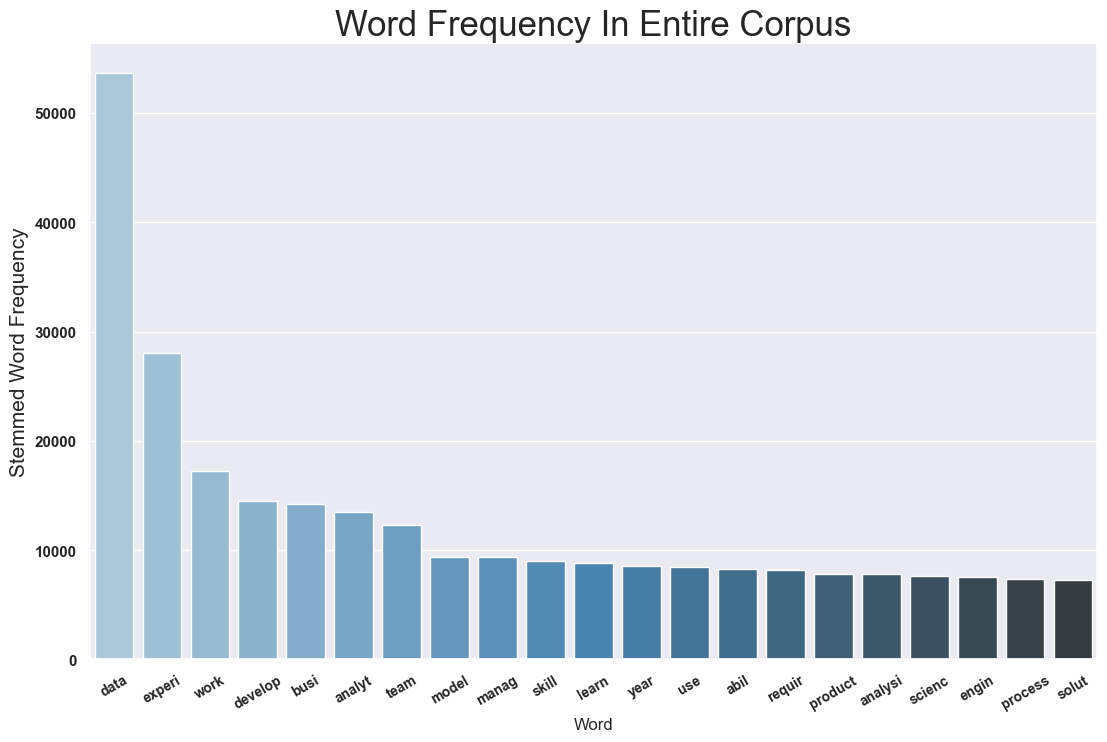

In [ ]:
#Barplot of most freq words

sns.barplot(rc={'figure.figsize':(20,15)})
stem_bar = sns.barplot(x="Word", y="Freq", data=top_stem[:21], palette="Blues_d")
plt.title('Word Frequency In Entire Corpus', size=25)
plt.ylabel('Stemmed Word Frequency', size = 15)
stem_bar.set_xticklabels(stem_bar.get_xticklabels(), rotation=30, fontsize = 10)


## (Lemmatized)

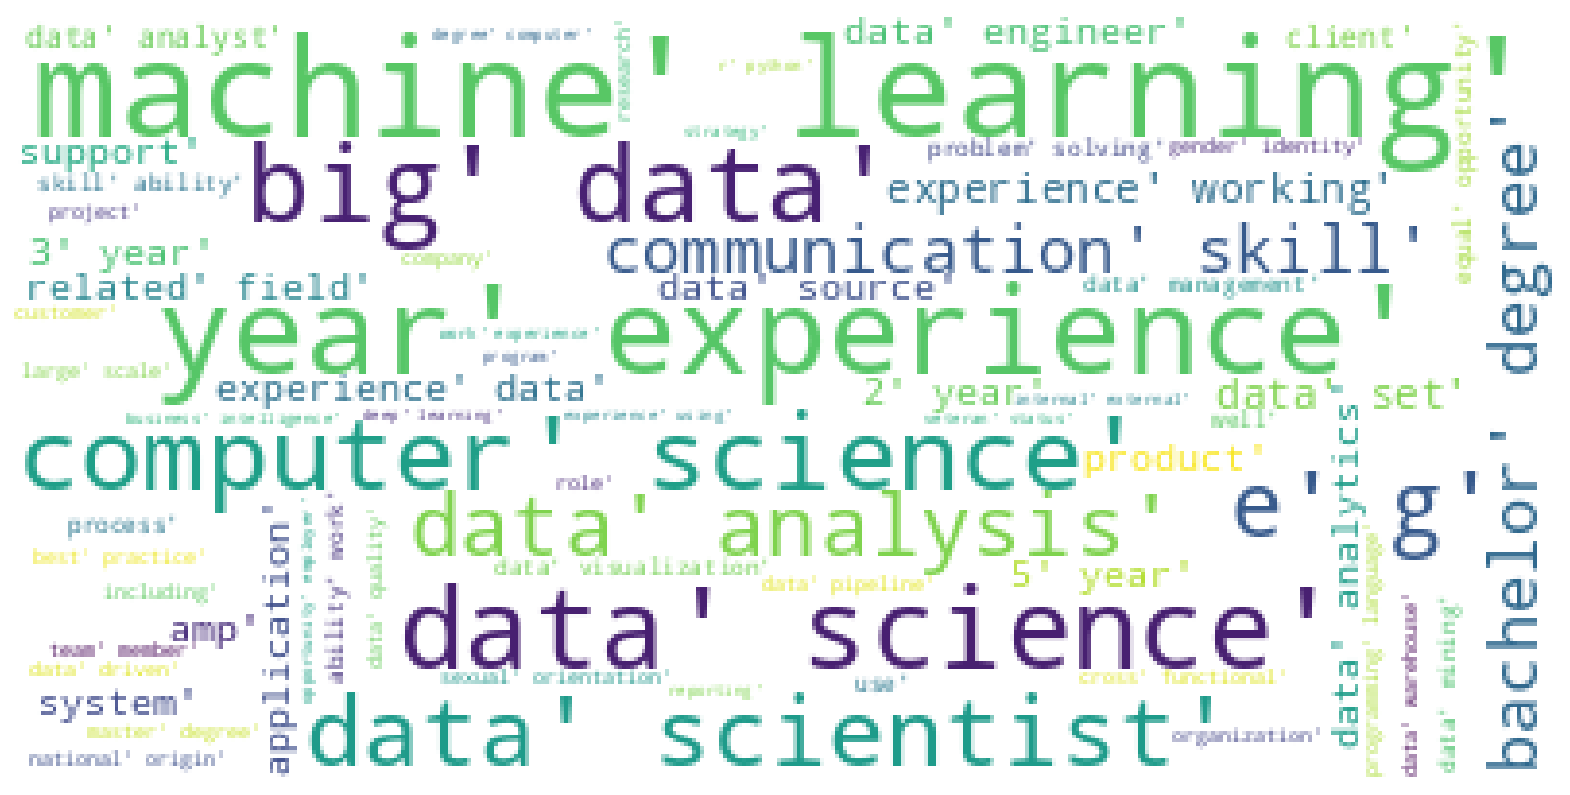

In [46]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(lem_corpus))

fig = plt.figure(1, figsize = (20,15))
plt.imshow(wordcloud)
plt.axis('off');
# wordcloud.to_file('lemma_wordcloud.png');


In [47]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(lem_corpus)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\670149888.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  lem_bar = sns.barplot(y = "Word", x = "Freq", data = top_df[:25], palette = "Blues_d", orient = 'h')
C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\670149888.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  lem_bar.set_yticklabels(lem_bar.get_yticklabels(), fontsize = 11)


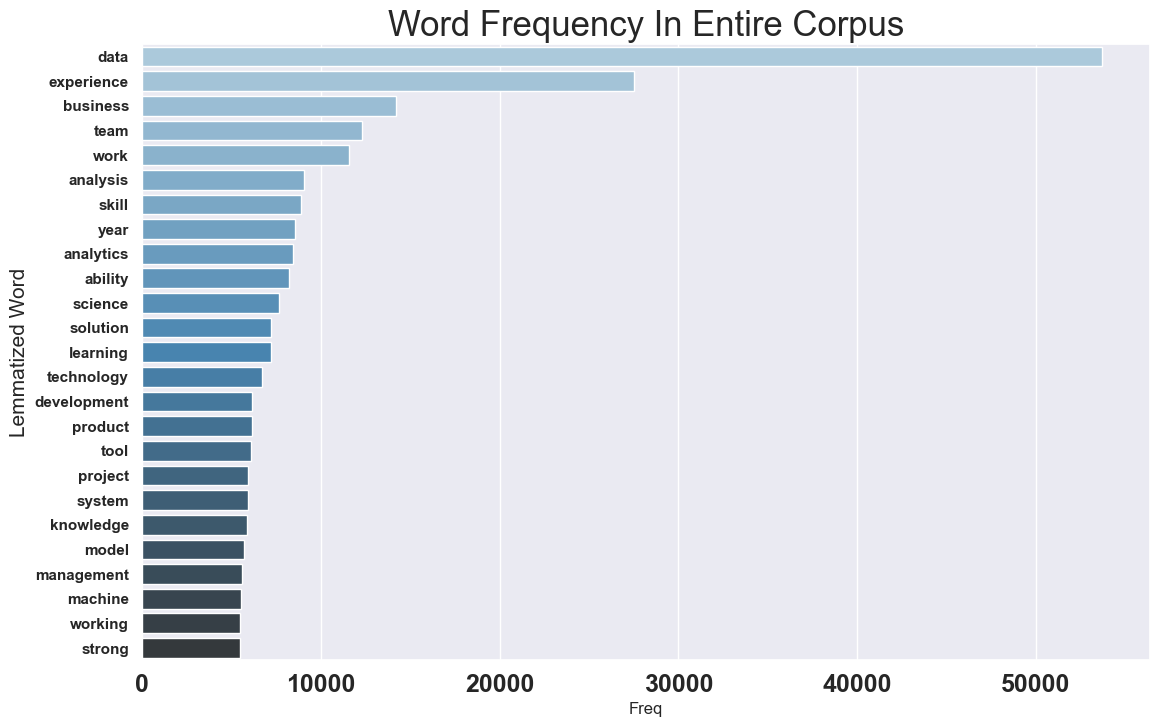

In [64]:
#Barplot of most freq words
lem_bar = sns.barplot(y = "Word", x = "Freq", data = top_df[:25], palette = "Blues_d", orient = 'h')
lem_bar.set_yticklabels(lem_bar.get_yticklabels(), fontsize = 11)
plt.title('Word Frequency In Entire Corpus', size=25)
plt.ylabel('Lemmatized Word', size = 15)
plt.xticks(size = 18)
plt.savefig('freqWords_bar.png', dpi=400)

In [49]:
# where does python fall within the word frequency dist
top_df.loc[top_df.Word == 'python']

,Word,Freq
41,python,4291


In [50]:
# test cell
# ident = top_df.loc[(top_df.Freq > 3) & (top_df.Freq < 2_000)]
# ident.head(50)

# N-grams

## Bigrams

In [51]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [52]:
# corpus with stopwords removed and list joined for n-gram distinction
ngram_corpus = df_desc.clean_words.str.join(' ')

In [53]:
top2_words = get_top_n2_words(ngram_corpus, n = len(ngram_corpus))
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]

C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\387661455.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bbar.set_yticklabels(bbar.get_yticklabels(), fontsize = 20);


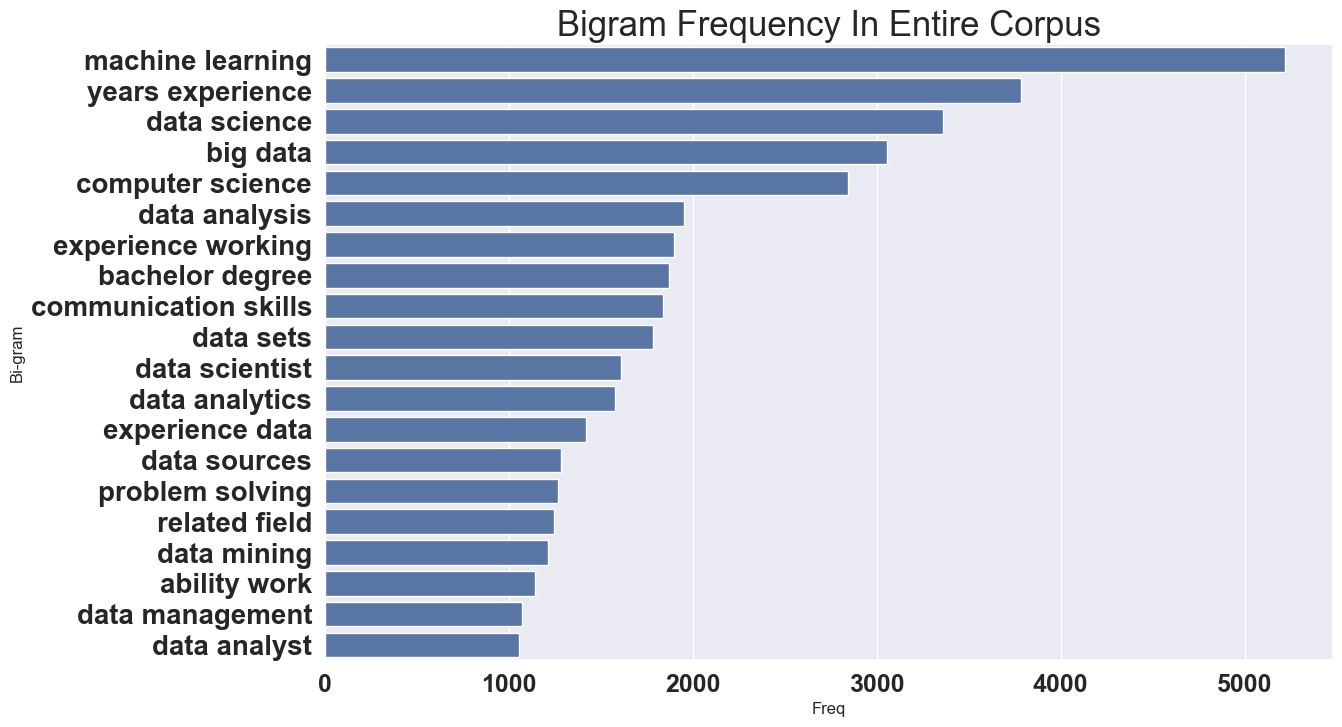

In [54]:
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
bbar = sns.barplot(y ="Bi-gram", x ="Freq", orient = 'h', data = top2_df[:20])
plt.title('Bigram Frequency In Entire Corpus', size=25)
plt.xticks(size = 18)
bbar.set_yticklabels(bbar.get_yticklabels(), fontsize = 20);
plt.savefig('bigram_bar.png', dpi=200)

In [55]:
top2_df[200:250]

,Bi-gram,Freq
200,new york,310
201,job description,309
202,medical dental,309
203,receive consideration,308
204,consideration employment,308
205,advanced degree,307
206,skills strong,307
207,data pipeline,307
208,product development,306
209,applicants receive,306


## Trigrams

In [56]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

In [57]:
top3_words = get_top_n3_words(ngram_corpus, n = len(ngram_corpus))
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Tri-gram", "Freq"]


C:\Users\sora sama\AppData\Local\Temp\ipykernel_15980\3941809849.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  tbar.set_yticklabels(tbar.get_yticklabels(), fontsize = 20);


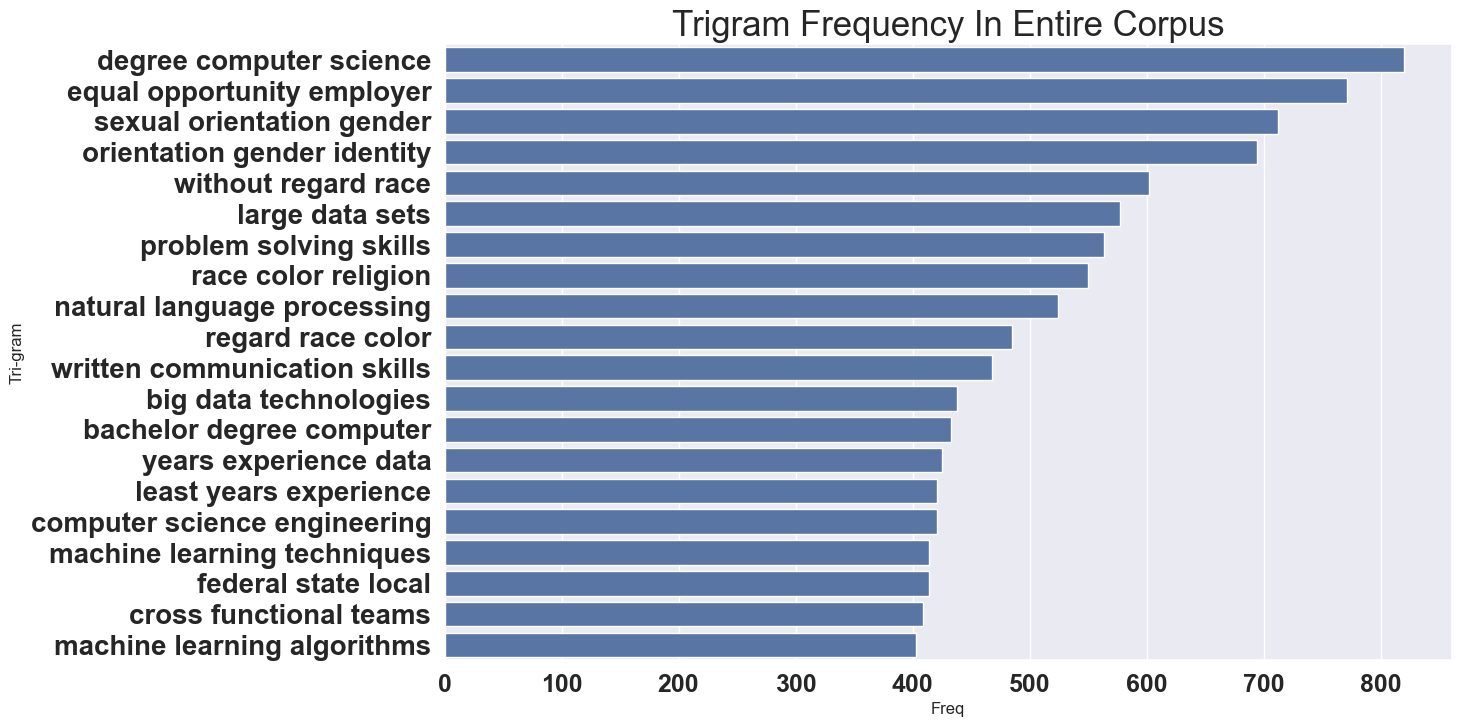

In [58]:
#Barplot of most freq Tri-grams
plt.tight_layout()
sns.set(rc={'figure.figsize':(13,8)})
tbar = sns.barplot(y = "Tri-gram", x = "Freq", orient = 'h', data = top3_df[:20])
plt.title('Trigram Frequency In Entire Corpus', size=25)
plt.xticks(size = 18)
tbar.set_yticklabels(tbar.get_yticklabels(), fontsize = 20);
plt.savefig('trigram_bar.png', dpi=200)

In [59]:
top3_df[200:250]

,Tri-gram,Freq
200,computer science data,102
201,strong verbal written,102
202,time series analysis,101
203,work cross functional,101
204,data mining techniques,100
205,real world problems,99
206,qualifications master degree,99
207,related technical field,99
208,equivalent combination education,99
209,ad hoc analysis,99


# Saving Dataset 


In [65]:
df_desc.to_csv('df_description_processed.csv', index = False)